
# Inverted Pendulum (CartPole) — PyTorch PPO (inline render, no files)
Trains a PPO policy and **renders inline** (no files) for both random actions and the trained policy.


In [35]:

# --- Imports & Config ---
import sys, random, math, time
import numpy as np

try:
    import gymnasium as gym
    GYM_LIB = "gymnasium"
except ImportError:
    import gym
    GYM_LIB = "gym"

import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt

print("Gym:", GYM_LIB, "| Python:", sys.version.split()[0], "| NumPy:", np.__version__, "| Torch:", torch.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print("Device:", DEVICE)

ENV_ID = "CartPole-v1"  # or "InvertedPendulum-v4" if you have MuJoCo
TOTAL_STEPS = 200_000
STEPS_PER_UPDATE = 2048
EPOCHS = 10
MINIBATCH_SIZE = 256
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.2
ENTROPY_COEF = 0.01
VALUE_COEF = 0.5
LEARNING_RATE = 3e-4
MAX_GRAD_NORM = 0.5
SEED = 42

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
set_seed(SEED)


Gym: gymnasium | Python: 3.9.21 | NumPy: 2.0.2 | Torch: 2.5.1+cu121
Device: cuda


In [36]:

# --- Unified Env Helpers ---
def make_env(env_id=ENV_ID, seed=SEED):
    env = gym.make(env_id)
    try: env.reset(seed=seed)
    except TypeError:
        try: env.seed(seed)
        except Exception: pass
    return env

def reset_env(env, seed=None):
    if seed is not None:
        try: out = env.reset(seed=seed)
        except TypeError: out = env.reset()
    else:
        out = env.reset()
    if isinstance(out, tuple) and len(out) == 2: obs, info = out; return obs, info
    return out, {}

def step_env(env, action):
    out = env.step(action)
    if len(out) == 5:
        obs, reward, terminated, truncated, info = out
        return obs, reward, (terminated or truncated), info
    elif len(out) == 4:
        obs, reward, done, info = out; return obs, reward, done, info
    else:
        raise RuntimeError("Unexpected env.step output signature.")


In [37]:

# --- Actor-Critic ---
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=(128,128)):
        super().__init__()
        self.policy = self._mlp(obs_dim, hidden, act_dim)
        self.value  = self._mlp(obs_dim, hidden, 1)
    @staticmethod
    def _mlp(in_dim, hidden, out_dim):
        layers=[]; last=in_dim
        for h in hidden: layers += [nn.Linear(last,h), nn.Tanh()]; last=h
        layers += [nn.Linear(last,out_dim)]
        return nn.Sequential(*layers)
    def forward(self, x):
        logits = self.policy(x); value = self.value(x).squeeze(-1)
        return logits, value
    def evaluate_actions(self, obs, actions):
        logits, values = self.forward(obs)
        dist = Categorical(logits=logits)
        logp = dist.log_prob(actions)
        entropy = dist.entropy()
        return logp, entropy, values


In [38]:

# --- Rollout Buffer & PPO Update ---
class RolloutBuffer:
    def __init__(self, obs_dim, size, device):
        self.obs = torch.zeros((size, obs_dim), dtype=torch.float32, device=device)
        self.actions = torch.zeros(size, dtype=torch.long, device=device)
        self.logp = torch.zeros(size, dtype=torch.float32, device=device)
        self.rewards = torch.zeros(size, dtype=torch.float32, device=device)
        self.dones = torch.zeros(size, dtype=torch.float32, device=device)
        self.values = torch.zeros(size, dtype=torch.float32, device=device)
        self.advantages = torch.zeros(size, dtype=torch.float32, device=device)
        self.returns = torch.zeros(size, dtype=torch.float32, device=device)
        self.ptr = 0; self.max_size = size
    def store(self, o, a, logp, r, d, v):
        self.obs[self.ptr] = torch.as_tensor(o, dtype=torch.float32, device=self.obs.device)
        self.actions[self.ptr] = int(a); self.logp[self.ptr] = float(logp)
        self.rewards[self.ptr] = float(r); self.dones[self.ptr] = float(d); self.values[self.ptr] = float(v)
        self.ptr += 1
    def compute_advantages(self, last_value, gamma, lam):
        adv = 0.0
        for t in reversed(range(self.ptr)):
            mask = 1.0 - self.dones[t]
            next_v = last_value if t==self.ptr-1 else self.values[t+1]
            delta = self.rewards[t] + gamma*next_v*mask - self.values[t]
            adv = delta + gamma*lam*mask*adv
            self.advantages[t] = adv
        self.returns[:self.ptr] = self.advantages[:self.ptr] + self.values[:self.ptr]
        a = self.advantages[:self.ptr]
        self.advantages[:self.ptr] = (a - a.mean()) / (a.std(unbiased=False) + 1e-8)
    def get(self, batch_size):
        idxs = np.arange(self.ptr); np.random.shuffle(idxs)
        for s in range(0, self.ptr, batch_size):
            e = s + batch_size; mb = idxs[s:e]
            yield self.obs[mb], self.actions[mb], self.logp[mb], self.advantages[mb], self.returns[mb]
    def reset(self): self.ptr = 0

def ppo_update(ac, optimizer, buffer):
    ac.train(); losses={"policy":[], "value":[], "entropy":[], "kl":[]}
    for _ in range(EPOCHS):
        for obs_b, act_b, logp_old_b, adv_b, ret_b in buffer.get(MINIBATCH_SIZE):
            logp_b, ent_b, val_b = ac.evaluate_actions(obs_b, act_b)
            ratio = torch.exp(logp_b - logp_old_b)
            surr1 = ratio * adv_b
            surr2 = torch.clamp(ratio, 1.0-CLIP_EPS, 1.0+CLIP_EPS) * adv_b
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = torch.nn.functional.smooth_l1_loss(val_b, ret_b)
            entropy_loss = -ent_b.mean()
            loss = policy_loss + VALUE_COEF*value_loss + ENTROPY_COEF*entropy_loss
            optimizer.zero_grad(set_to_none=True); loss.backward()
            torch.nn.utils.clip_grad_norm_(ac.parameters(), MAX_GRAD_NORM); optimizer.step()
            with torch.no_grad(): approx_kl = (logp_old_b - logp_b).mean().cpu().item()
            losses["policy"].append(policy_loss.item())
            losses["value"].append(value_loss.item())
            losses["entropy"].append(-entropy_loss.item())
            losses["kl"].append(approx_kl)
    return {k: float(np.mean(v)) for k,v in losses.items()}


In [39]:

# --- Training ---
def train_ppo(env_id=ENV_ID, total_steps=TOTAL_STEPS, steps_per_update=STEPS_PER_UPDATE):
    env = make_env(env_id, seed=SEED)
    obs0,_ = reset_env(env, seed=SEED)
    obs_dim = int(np.prod(env.observation_space.shape))
    assert hasattr(env.action_space, "n"), "This PPO setup expects discrete actions (CartPole)."
    act_dim = env.action_space.n
    ac = ActorCritic(obs_dim, act_dim).to(DEVICE)
    optimizer = torch.optim.Adam(ac.parameters(), lr=LEARNING_RATE)
    buf = RolloutBuffer(obs_dim, steps_per_update, device=DEVICE)

    ep_rets=[]; ep_ret=0.0; obs=np.array(obs0, dtype=np.float32); t_global=0
    while t_global < total_steps:
        buf.reset()
        for t in range(steps_per_update):
            obs_t = torch.as_tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            with torch.no_grad():
                logits, value = ac(obs_t)
                dist = Categorical(logits=logits)
                action = dist.sample(); logp = dist.log_prob(action)
            next_obs, r, done, info = step_env(env, int(action.item()))
            ep_ret += float(r)
            buf.store(obs, action.item(), logp.item(), r, done, value.item())
            t_global += 1; obs = next_obs
            if done:
                ep_rets.append(ep_ret); ep_ret=0.0; obs,_ = reset_env(env)
        with torch.no_grad(): _, last_v = ac(torch.as_tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0))
        buf.compute_advantages(last_v.item(), GAMMA, LAMBDA)
        stats = ppo_update(ac, optimizer, buf)
        if len(ep_rets)%5==0 and ep_rets:
            print(f"Steps {t_global}/{total_steps} | LastEpRet {ep_rets[-1]:.1f} | π {stats['policy']:.3f} V {stats['value']:.3f} H {stats['entropy']:.3f} KL {stats['kl']:.5f}")
    env.close(); return ac, ep_rets

print("PPO setup complete. Ready to train.")


PPO setup complete. Ready to train.


In [40]:

# --- Inline Rendering Helpers (no files) ---
from io import BytesIO
import numpy as np
from IPython.display import Image, HTML, display
import matplotlib.pyplot as plt
try:
    import imageio.v2 as imageio
    _HAS_IMAGEIO=True
except Exception:
    _HAS_IMAGEIO=False

def _make_env_rgb(env_id):
    try:
        env = gym.make(env_id, render_mode="rgb_array"); return env, "new"
    except TypeError:
        env = gym.make(env_id); return env, "old"

def _render_frame(env, flag):
    if flag=="new":
        try:
            fr = env.render()
            if isinstance(fr, np.ndarray): return fr
        except Exception: return None
    else:
        try: return env.render(mode="rgb_array")
        except Exception: return None
    return None

def _to_inline_video(frames, fps=30):
    if not frames:
        print("No frames to display."); return
    if _HAS_IMAGEIO:
        try:
            buf=BytesIO(); imageio.mimsave(buf, frames, format="GIF", fps=fps); buf.seek(0)
            display(Image(data=buf.read(), format='gif')); return
        except Exception as e:
            print("GIF failed, falling back to JS animation:", e)
    from matplotlib import animation
    fig, ax = plt.subplots(); ax.axis("off"); im=ax.imshow(frames[0])
    def animate(i): im.set_data(frames[i]); return (im,)
    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=1000/fps, blit=True)
    html = anim.to_jshtml(); plt.close(fig); display(HTML(html))

def show_random_inline(env_id=ENV_ID, steps=300, fps=30):
    env,flag=_make_env_rgb(env_id); obs,_=reset_env(env)
    frames=[]; f0=_render_frame(env,flag); 
    if f0 is not None: frames.append(f0)
    for _ in range(steps):
        if hasattr(env.action_space,"n"): a = env.action_space.sample()
        else: print("Discrete action space expected for random demo."); break
        obs,r,done,info = step_env(env,a)
        fr=_render_frame(env,flag); 
        if fr is not None: frames.append(fr)
        if done: break
    env.close(); _to_inline_video(frames,fps=fps)

def show_trained_inline(ac, env_id=ENV_ID, max_steps=500, fps=30):
    env,flag=_make_env_rgb(env_id); obs,_=reset_env(env)
    frames=[]; f0=_render_frame(env,flag); 
    if f0 is not None: frames.append(f0)
    steps=0
    while steps<max_steps:
        obs_t=torch.as_tensor(obs,dtype=torch.float32,device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            logits,_ = ac(obs_t); action = torch.argmax(logits, dim=-1).item()
        obs,r,done,info = step_env(env,int(action))
        fr=_render_frame(env,flag); 
        if fr is not None: frames.append(fr)
        steps+=1
        if done: break
    env.close(); _to_inline_video(frames,fps=fps)


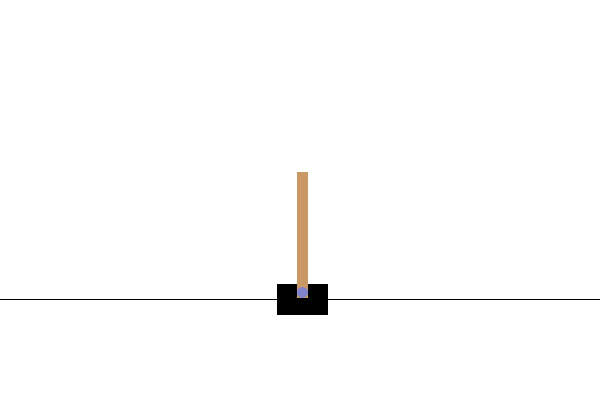

In [47]:

# --- Preview the environment with RANDOM actions (inline, no files) ---
show_random_inline(env_id=ENV_ID, steps=10000000, fps=30)


Steps 2048/200000 | LastEpRet 42.0 | π -0.018 V 5.646 H 0.687 KL 0.00943
Steps 4096/200000 | LastEpRet 17.0 | π -0.014 V 5.459 H 0.671 KL 0.00639
Steps 14336/200000 | LastEpRet 171.0 | π -0.006 V 8.960 H 0.619 KL 0.00508
Steps 22528/200000 | LastEpRet 72.0 | π -0.005 V 8.432 H 0.590 KL 0.00469
Steps 28672/200000 | LastEpRet 184.0 | π -0.004 V 7.383 H 0.582 KL 0.00360
Steps 36864/200000 | LastEpRet 219.0 | π -0.007 V 4.545 H 0.580 KL 0.00718
Steps 47104/200000 | LastEpRet 500.0 | π -0.004 V 3.979 H 0.580 KL 0.00599
Steps 49152/200000 | LastEpRet 205.0 | π -0.006 V 6.737 H 0.577 KL 0.00810
Steps 53248/200000 | LastEpRet 123.0 | π -0.005 V 8.015 H 0.587 KL 0.00395
Steps 55296/200000 | LastEpRet 118.0 | π -0.008 V 7.340 H 0.583 KL 0.00331
Steps 71680/200000 | LastEpRet 500.0 | π -0.002 V 3.067 H 0.564 KL 0.00117
Steps 90112/200000 | LastEpRet 500.0 | π -0.001 V 3.095 H 0.585 KL 0.00308
Steps 92160/200000 | LastEpRet 500.0 | π -0.005 V 3.759 H 0.562 KL 0.00465
Steps 100352/200000 | LastEpRe

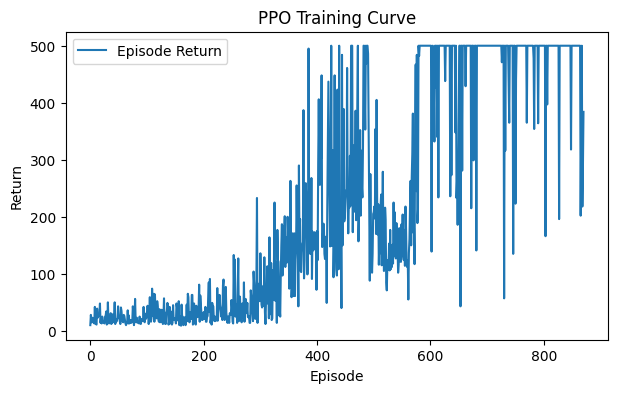

In [42]:

# --- Train PPO ---
ac, ep_rets = train_ppo(ENV_ID, TOTAL_STEPS, STEPS_PER_UPDATE)
print("Training finished. Episodes logged:", len(ep_rets))
plt.figure(figsize=(7,4)); plt.plot(ep_rets, label="Episode Return"); plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("PPO Training Curve"); plt.legend(); plt.show()


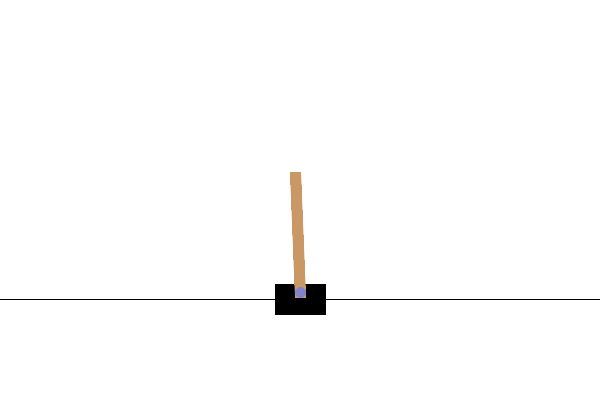

In [48]:

# --- Render the TRAINED policy inline (no files) ---
show_trained_inline(ac, env_id=ENV_ID, max_steps=100000, fps=30)
